In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset

%load_ext autoreload
%autoreload 2

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Get dataset

In [5]:
DATA_PATH = "ReadyData.csv"

In [6]:
dataset = Dataset(DATA_PATH)
dictionary = dataset.get_dictionary()

## Make initial model

In [7]:
from topicnet.cooking_machine.model_constructor import init_simple_default_model

n_topics = 100
n_background = 10
model_artm = init_simple_default_model(
    dataset=dataset,
    modalities_to_use=dataset.get_possible_modalities(),
    main_modality='@word',
    specific_topics=n_topics - n_background,
    background_topics=n_background,
)
specific_topics, bacground_topics = model_artm.topic_names[:-n_background], model_artm.topic_names[-n_background:]
model_artm.scores

[PerplexityScore@all, SparsityThetaScore, SparsityPhiScore@word, PerplexityScore@word, TopicKernel@word]

### DEFINE TOPIC MODEL

In [9]:
#scores = {'Perplexy': MyPerplexityScore()}
model = TopicModel(model_artm, model_id='YaninaDemo3')

### Define experiment

In [10]:
from topicnet.cooking_machine.experiment import Experiment
experiment = Experiment(experiment_id='YaninaDemo3', save_path='YaninaDemo3', topic_model=model)

## Cubes

In [11]:
cube1 = RegularizersModifierCube(
    num_iter=8,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters={
        'regularizer': artm.SmoothSparsePhiRegularizer(
                 name='smooth_phi_bcg',
                 topic_names=bacground_topics,
                 tau=1,
                 class_ids=['@word']),
        'tau_grid': [0, 10, 20, 30, 40],
    },
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

In [12]:
cube2 = RegularizersModifierCube(
    num_iter=8,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters={
        "regularizer": artm.SmoothSparseThetaRegularizer(
                 name='smooth_theta_bcg',
                 topic_names=bacground_topics,
                 tau=1),
        'tau_grid': [0, 10, 20, 30, 40],
    },
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

In [13]:
cube3 = RegularizersModifierCube(
    num_iter=8,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters={
        'regularizer': artm.DecorrelatorPhiRegularizer(
             name=f'decorrelation_phi_{"@word"}',
             topic_names=specific_topics,
             tau=1,
             class_ids=['@word']),
        'tau_grid': [10**4, 10**5, 10**6, 10**7, 10**8, 10**9, 10**10],
    },
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

In [14]:
cube4 = RegularizersModifierCube(
    num_iter=8,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters={
        'regularizer': artm.SmoothSparseThetaRegularizer(
                 name=f'sparse_Theta{"@word"}',
                 topic_names=specific_topics,
                 tau=1),
        'tau_grid': [0, -0.25, -0.75, -2.0],
    },
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

In [16]:
cube5 = RegularizersModifierCube(
    num_iter=8,
    tracked_score_function=retrieve_score_for_strategy('PerplexityScore@all'),
    regularizer_parameters={
        'regularizer': artm.SmoothSparsePhiRegularizer(
                 name='smooth_Phi',
                 topic_names=specific_topics,
                 tau=1),
        'tau_grid': [0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    },
    reg_search='grid',
    relative_coefficients=False,
    verbose=True
)

### SHOW GO ON

In [17]:
start_time = time.time()
models = cube1(model, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 5/5 [02:09<00:00, 26.15s/it]


--- 254.96778464317322 seconds ---


In [18]:
models = experiment.select(f'PerplexityScore@all -> min')

In [19]:
start_time = time.time()
models = cube2(models, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 5/5 [02:17<00:00, 27.70s/it]


--- 283.92696356773376 seconds ---


In [20]:
start_time = time.time()
models = experiment.select(f'PerplexityScore@all -> min')
print("--- %s seconds ---" % (time.time() - start_time))

--- 8.70707106590271 seconds ---


In [21]:
start_time = time.time()
models = cube3(models, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 7/7 [03:44<00:00, 31.48s/it]


--- 463.91751074790955 seconds ---


In [22]:
start_time = time.time()
models = experiment.select(f'PerplexityScore@all -> min')
print("--- %s seconds ---" % (time.time() - start_time))

--- 16.998926877975464 seconds ---


In [23]:
start_time = time.time()
models = cube4(models, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 4/4 [02:15<00:00, 33.59s/it]


--- 266.6931149959564 seconds ---


In [24]:
start_time = time.time()
models = experiment.select(f'PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore{"@word"}) \
                  and SparsityPhiScore{"@word"} -> max')
print("--- %s seconds ---" % (time.time() - start_time))

--- 12.837584495544434 seconds ---


In [25]:
start_time = time.time()
models = cube5(models, dataset)
print("--- %s seconds ---" % (time.time() - start_time))

100%|██████████| 8/8 [05:07<00:00, 40.30s/it]


--- 754.9396774768829 seconds ---


In [26]:
start_time = time.time()
models = experiment.select(f'PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore{"@word"}) \
                  and SparsityPhiScore{"@word"} -> max')
print("--- %s seconds ---" % (time.time() - start_time))

--- 33.79815649986267 seconds ---


In [27]:
models

In [28]:
from IPython.core.display import display, HTML


display(HTML("""<style>
div.output_html {  
    white-space: nowrap;  
}
div .output_subarea > pre {  
    white-space: pre;  
    word-wrap: normal;  
}
</style>"""))

In [29]:
experiment.show()

Experiment YaninaDemo3

Experiment was made with BigARTM 0.9.0
Tree:
                                                                                                                                                                                                                                                                              ┌#                                       #18h53m37s_22d10m2019y                                       ###
                                                                                                                                                                                                                                                                              ├#                                       #18h54m11s_22d10m2019y                                       ###
                                                                                                                                                                                   

In [30]:
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

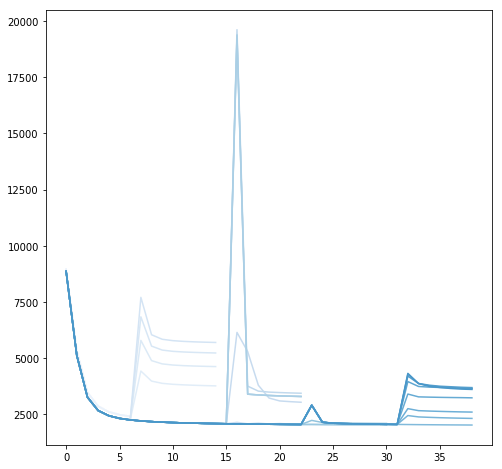

In [31]:
from matplotlib import cm

tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[2:]):
    perp_score = tm.scores['PerplexityScore@all']
    plt.plot(perp_score[1:], color=cm.Blues(colors[i]))
plt.show()

0.5487495064735413
0.5487495064735413
0.548750638961792
0.5487517714500427
0.8440211415290833
0.8550730347633362
0.8610220551490784
0.8652969598770142
0.8685572743415833
0.8799999952316284
0.8886910080909729
0.9792827367782593
0.9830993413925171
0.98417729139328
0.9842287302017212
0.9842730164527893
0.8931396007537842
0.8926883339881897
0.8929107785224915
0.8983959555625916
0.9019222855567932
0.08901780843734741
0.08895596116781235
0.08884567022323608
0.08877450227737427
0.08874767273664474
0.08874059468507767
0.08873835951089859


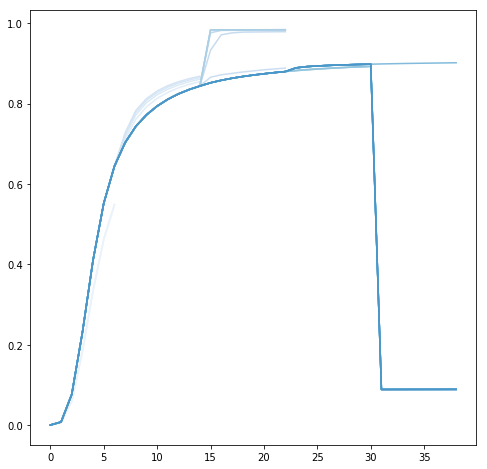

In [32]:
tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[2:]):
    perp_score = tm.scores['SparsityPhiScore@word']
    plt.plot(perp_score[1:], color=cm.Blues(colors[i]))
    print(perp_score[-1])
plt.show()

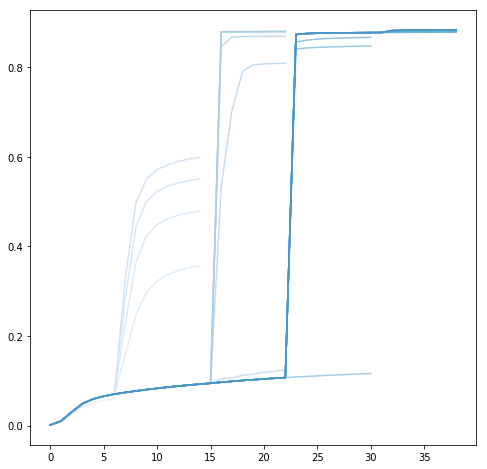

In [33]:
tms = experiment.models
n=len(tms)
colors = np.linspace(0, 0.65, n)

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[2:]):
    perp_score = tm.scores['SparsityThetaScore']
    plt.plot(perp_score[1:], color=cm.Blues(colors[i]))
plt.show()